<a href="https://colab.research.google.com/github/jessyzhang92/Helloword/blob/master/PixelCNN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
os.makedirs("samples", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])

Using device: cuda


In [2]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_size = 10000
train_size = len(train_dataset) - val_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


In [3]:
# model definition
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mask_type = mask_type
        H, W = self.kernel_size
        mask = torch.ones(self.weight.shape)
        mask[:, :, H//2, W//2 + (0 if mask_type == 'B' else 1):] = 0
        mask[:, :, H//2 + 1:] = 0
        self.register_buffer('mask', mask)

    def forward(self, x):
        return nn.functional.conv2d(x, self.weight * self.mask, self.bias, self.stride, self.padding)

class DeepPixelCNN(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=8):
        super().__init__()
        layers = []
        layers.append(MaskedConv2d('A', 1, hidden_dim, 7, padding=3))
        layers.append(nn.ReLU())
        for _ in range(num_layers):
            layers.append(MaskedConv2d('B', hidden_dim, hidden_dim, 3, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.Conv2d(hidden_dim, 1, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)

model = DeepPixelCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [4]:
#record the samples in process and show them in console
GENERATION_STAGES = [1, 21, 41, 61, 81]
saved_samples = []
NUM_SAMPLES_PER_STAGE = 4

@torch.no_grad()
def generate_sample_for_display():
    model.eval()
    x = torch.zeros(NUM_SAMPLES_PER_STAGE, 1, 28, 28).to(device)
    for i in range(28):
        for j in range(28):
            logits = model(x)
            prob = torch.sigmoid(logits[:, i, j])
            x[:, :, i, j] = torch.bernoulli(prob).unsqueeze(-1)
            del logits, prob
    return x.cpu()

@torch.no_grad()
def show_sample_in_console(epoch):
    model.eval()
    x = torch.zeros(10, 1, 28, 28).to(device)
    for i in range(28):
        for j in range(28):
            logits = model(x)
            prob = torch.sigmoid(logits[:, i, j])
            x[:, :, i, j] = torch.bernoulli(prob).unsqueeze(-1)
            del logits, prob
    imgs = x.cpu().squeeze(1)

    fig, axes = plt.subplots(1, 10, figsize=(12, 1.5))
    for i in range(10):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Generated Samples - Epoch {epoch+1}", fontsize=14)
    plt.tight_layout()
    plt.show()

Starting training...
Epoch 1/100, Train Loss: 0.2665
              Validation Loss: 0.2470
Epoch 2/100, Train Loss: 0.2391
              Validation Loss: 0.2338
[Progress] Generated 4 samples at epoch 2 for final showcase.


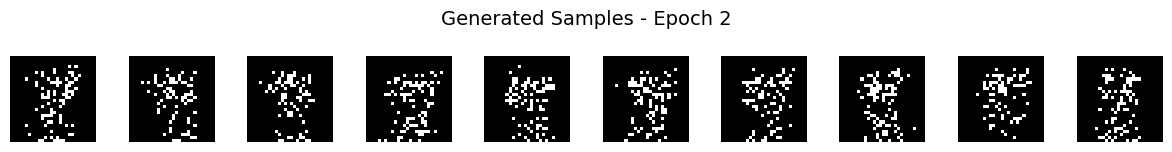

Epoch 3/100, Train Loss: 0.2320
              Validation Loss: 0.2279
Epoch 4/100, Train Loss: 0.2279
              Validation Loss: 0.2260
Epoch 5/100, Train Loss: 0.2254
              Validation Loss: 0.2252
Epoch 6/100, Train Loss: 0.2235
              Validation Loss: 0.2237
Epoch 7/100, Train Loss: 0.2222
              Validation Loss: 0.2226
Epoch 8/100, Train Loss: 0.2211
              Validation Loss: 0.2217
Epoch 9/100, Train Loss: 0.2202
              Validation Loss: 0.2208
Epoch 10/100, Train Loss: 0.2194
              Validation Loss: 0.2206
Epoch 11/100, Train Loss: 0.2187
              Validation Loss: 0.2206
Epoch 12/100, Train Loss: 0.2182
              Validation Loss: 0.2205
Epoch 13/100, Train Loss: 0.2176
              Validation Loss: 0.2200
Epoch 14/100, Train Loss: 0.2170
              Validation Loss: 0.2194
Epoch 15/100, Train Loss: 0.2166
              Validation Loss: 0.2197
Epoch 16/100, Train Loss: 0.2161
              Validation Loss: 0.2193
Epoch 17/100,

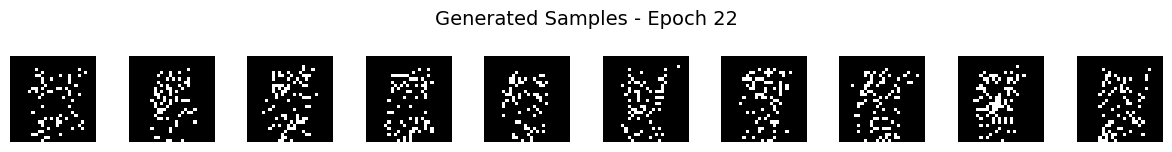

Epoch 23/100, Train Loss: 0.2135
              Validation Loss: 0.2199
Epoch 24/100, Train Loss: 0.2131
              Validation Loss: 0.2200
Epoch 25/100, Train Loss: 0.2128
              Validation Loss: 0.2199
Epoch 26/100, Train Loss: 0.2125
              Validation Loss: 0.2200
Epoch 27/100, Train Loss: 0.2122
              Validation Loss: 0.2205
Epoch 28/100, Train Loss: 0.2119
              Validation Loss: 0.2202
Epoch 29/100, Train Loss: 0.2116
              Validation Loss: 0.2205
Epoch 30/100, Train Loss: 0.2114
              Validation Loss: 0.2209
Epoch 31/100, Train Loss: 0.2111
              Validation Loss: 0.2204
Epoch 32/100, Train Loss: 0.2108
              Validation Loss: 0.2213
Epoch 33/100, Train Loss: 0.2105
              Validation Loss: 0.2206
Epoch 34/100, Train Loss: 0.2103
              Validation Loss: 0.2213
Epoch 35/100, Train Loss: 0.2101
              Validation Loss: 0.2213
Epoch 36/100, Train Loss: 0.2098
              Validation Loss: 0.2221
Epoch 

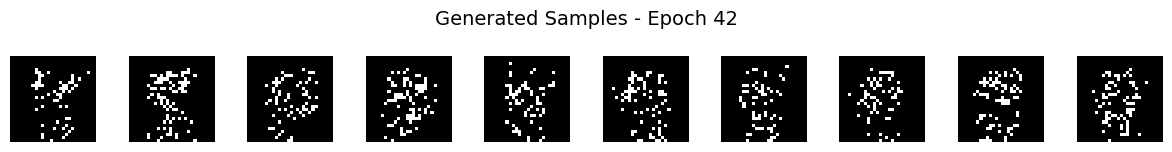

Epoch 43/100, Train Loss: 0.2082
              Validation Loss: 0.2228
Epoch 44/100, Train Loss: 0.2080
              Validation Loss: 0.2234
Epoch 45/100, Train Loss: 0.2078
              Validation Loss: 0.2230
Epoch 46/100, Train Loss: 0.2076
              Validation Loss: 0.2234
Epoch 47/100, Train Loss: 0.2074
              Validation Loss: 0.2236
Epoch 48/100, Train Loss: 0.2072
              Validation Loss: 0.2248
Epoch 49/100, Train Loss: 0.2069
              Validation Loss: 0.2246
Epoch 50/100, Train Loss: 0.2067
              Validation Loss: 0.2251
Epoch 51/100, Train Loss: 0.2066
              Validation Loss: 0.2236
Epoch 52/100, Train Loss: 0.2064
              Validation Loss: 0.2253
Epoch 53/100, Train Loss: 0.2062
              Validation Loss: 0.2245
Epoch 54/100, Train Loss: 0.2060
              Validation Loss: 0.2246
Epoch 55/100, Train Loss: 0.2059
              Validation Loss: 0.2249
Epoch 56/100, Train Loss: 0.2057
              Validation Loss: 0.2255
Epoch 

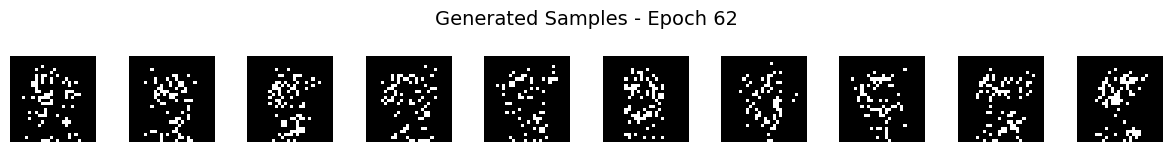

Epoch 63/100, Train Loss: 0.2047
              Validation Loss: 0.2268
Epoch 64/100, Train Loss: 0.2046
              Validation Loss: 0.2274
Epoch 65/100, Train Loss: 0.2043
              Validation Loss: 0.2288
Epoch 66/100, Train Loss: 0.2043
              Validation Loss: 0.2275
Epoch 67/100, Train Loss: 0.2042
              Validation Loss: 0.2270
Epoch 68/100, Train Loss: 0.2039
              Validation Loss: 0.2281
Epoch 69/100, Train Loss: 0.2038
              Validation Loss: 0.2298
Epoch 70/100, Train Loss: 0.2037
              Validation Loss: 0.2271
Epoch 71/100, Train Loss: 0.2035
              Validation Loss: 0.2289
Epoch 72/100, Train Loss: 0.2036
              Validation Loss: 0.2288
Epoch 73/100, Train Loss: 0.2033
              Validation Loss: 0.2288
Epoch 74/100, Train Loss: 0.2033
              Validation Loss: 0.2287
Epoch 75/100, Train Loss: 0.2031
              Validation Loss: 0.2289
Epoch 76/100, Train Loss: 0.2029
              Validation Loss: 0.2314
Epoch 

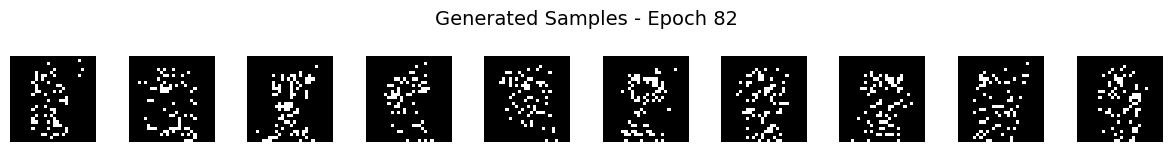

Epoch 83/100, Train Loss: 0.2022
              Validation Loss: 0.2283
Epoch 84/100, Train Loss: 0.2019
              Validation Loss: 0.2294
Epoch 85/100, Train Loss: 0.2020
              Validation Loss: 0.2368
Epoch 86/100, Train Loss: 0.2019
              Validation Loss: 0.2328
Epoch 87/100, Train Loss: 0.2016
              Validation Loss: 0.2316
Epoch 88/100, Train Loss: 0.2017
              Validation Loss: 0.2316
Epoch 89/100, Train Loss: 0.2018
              Validation Loss: 0.2295
Epoch 90/100, Train Loss: 0.2015
              Validation Loss: 0.2312
Epoch 91/100, Train Loss: 0.2012
              Validation Loss: 0.2322
Epoch 92/100, Train Loss: 0.2011
              Validation Loss: 0.2340
Epoch 93/100, Train Loss: 0.2011
              Validation Loss: 0.2333
Epoch 94/100, Train Loss: 0.2010
              Validation Loss: 0.2340
Epoch 95/100, Train Loss: 0.2008
              Validation Loss: 0.2318
Epoch 96/100, Train Loss: 0.2009
              Validation Loss: 0.2340
Epoch 

In [5]:
# ========== training ==========
print("Starting training...")
start_train_time = time.time()
losses = []
num_epochs = 100

for epoch in range(num_epochs):
    # if early_stop:
    #     print("Early stopping triggered. Training halted.")
    #     break

    model.train()
    epoch_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        logits = model(x)
        loss = criterion(logits, x.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        del x, logits, loss

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            logits = model(x)
            loss = criterion(logits, x.squeeze(1))
            val_loss += loss.item()
            del x, logits, loss
    avg_val_loss = val_loss / len(val_loader)
    print(f"              Validation Loss: {avg_val_loss:.4f}")

    # if avg_val_loss < best_val_loss:
    #     best_val_loss = avg_val_loss
    #     epochs_without_improvement = 0
    #     torch.save(model.state_dict(), "checkpoints/pixelcnn_best.pth")
    #     print(f"Best model saved at epoch {epoch+1}")
    # else:
    #     epochs_without_improvement += 1
    #     print(f"No improvement in validation loss for {epochs_without_improvement} epoch(s)")

    # if epochs_without_improvement >= patience:
    #     early_stop = True


    if epoch in GENERATION_STAGES:
        sample_img = generate_sample_for_display()
        saved_samples.append((epoch + 1, sample_img))
        print(f"[Progress] Generated {NUM_SAMPLES_PER_STAGE} samples at epoch {epoch+1} for final showcase.")
        show_sample_in_console(epoch)

end_train_time = time.time()
total_train_time = end_train_time - start_train_time
print(f"\nTraining completed in {total_train_time:.2f} seconds.")


In [6]:
# test set
@torch.no_grad()
def evaluate_on_test():
    model.eval()
    test_loss = 0.0
    for x, _ in test_loader:
        x = x.to(device)
        logits = model(x)
        loss = criterion(logits, x.squeeze(1))
        test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    print(f"\nFinal Test Loss: {avg_test_loss:.4f}")
    return avg_test_loss

evaluate_on_test()


Final Test Loss: 0.2343


0.23429322471253025

Inference time for 10 images: 0.7666 seconds

Showing generation progress in 5×4 grid...


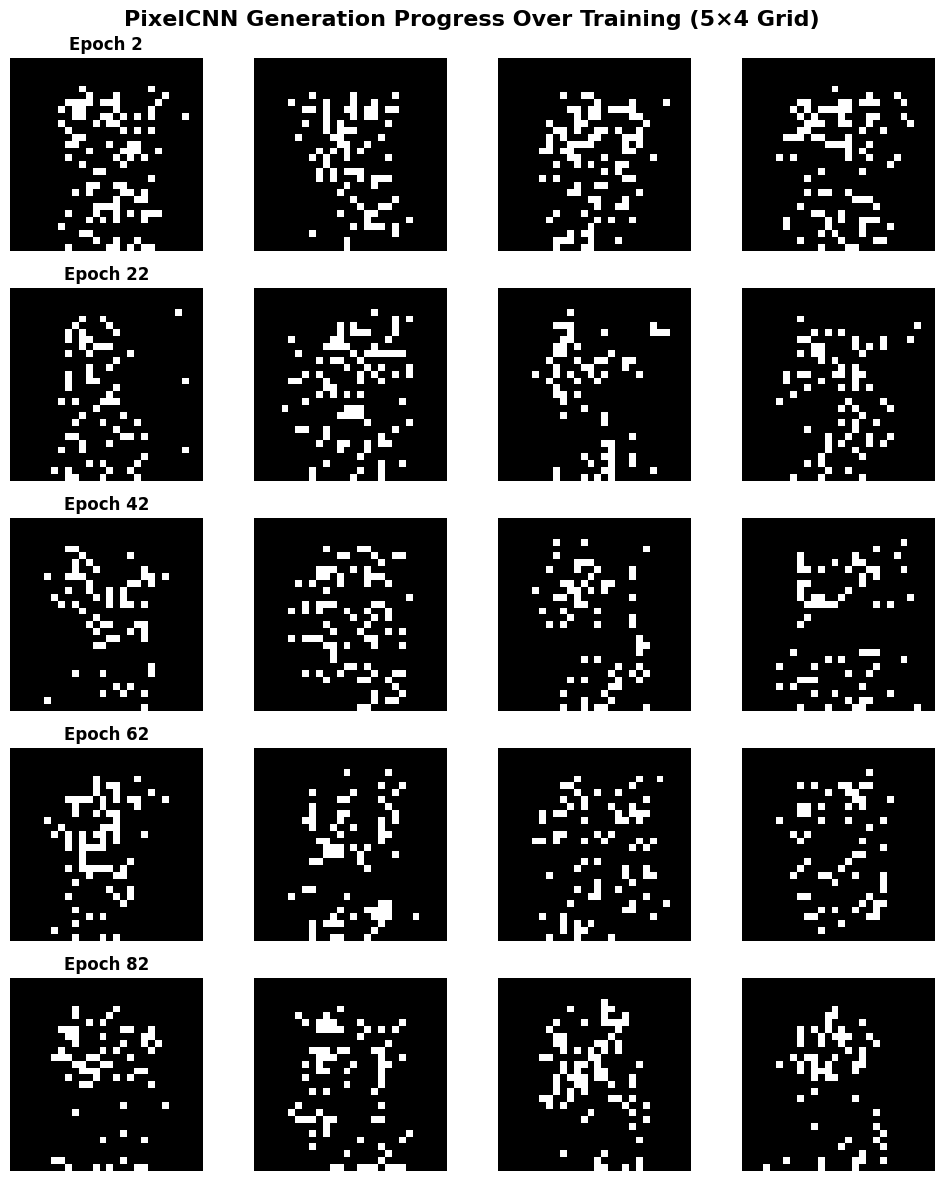

Generating samples with temp=1.0...


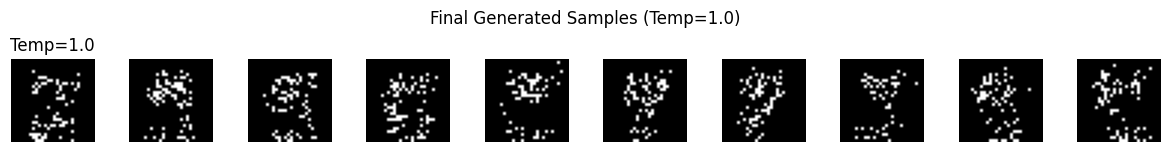

In [7]:
# Measure inference time
@torch.no_grad()
def measure_inference_time(batch_size=10):
    model.eval()
    x = torch.zeros(batch_size, 1, 28, 28).to(device)
    start = time.time()
    for i in range(28):
        for j in range(28):
            logits = model(x)
            prob = torch.sigmoid(logits[:, i, j])
            x[:, :, i, j] = torch.bernoulli(prob).unsqueeze(-1)
    end = time.time()
    return end - start

inference_time = measure_inference_time(batch_size=10)
print(f"Inference time for 10 images: {inference_time:.4f} seconds")

# Show Generation Progress in 5×4 Grid
print("\nShowing generation progress in 5×4 grid...")
fig, axes = plt.subplots(len(GENERATION_STAGES), NUM_SAMPLES_PER_STAGE, figsize=(10, 12))
fig.suptitle("PixelCNN Generation Progress Over Training (5×4 Grid)", fontsize=16, fontweight='bold')

for row, (epoch, img_tensor) in enumerate(saved_samples):
    imgs = img_tensor.squeeze(1).numpy()
    for col in range(NUM_SAMPLES_PER_STAGE):
        axes[row, col].imshow(imgs[col], cmap='gray')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(f"Epoch {epoch}", fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# Final samples with temp
temps = [1.0]
fig, axes = plt.subplots(1, 10, figsize=(12, 1.5))

for idx, temp in enumerate(temps):
    print(f"Generating samples with temp={temp}...")
    torch.cuda.empty_cache()
    model.eval()
    with torch.no_grad():
        x = torch.zeros(10, 1, 28, 28).to(device)
        for i in range(28):
            for j in range(28):
                logits = model(x)
                prob = torch.sigmoid(logits[:, i, j] / temp)
                x[:, :, i, j] = torch.bernoulli(prob).unsqueeze(-1)
                del logits, prob
        imgs = x.cpu().numpy().squeeze(1)

    for j in range(10):
        axes[j].imshow(imgs[j], cmap='gray')
        axes[j].axis('off')
        if j == 0:
            axes[j].set_title(f"Temp={temp}")

plt.suptitle(f"Final Generated Samples (Temp={temp})")
plt.tight_layout()
plt.show()

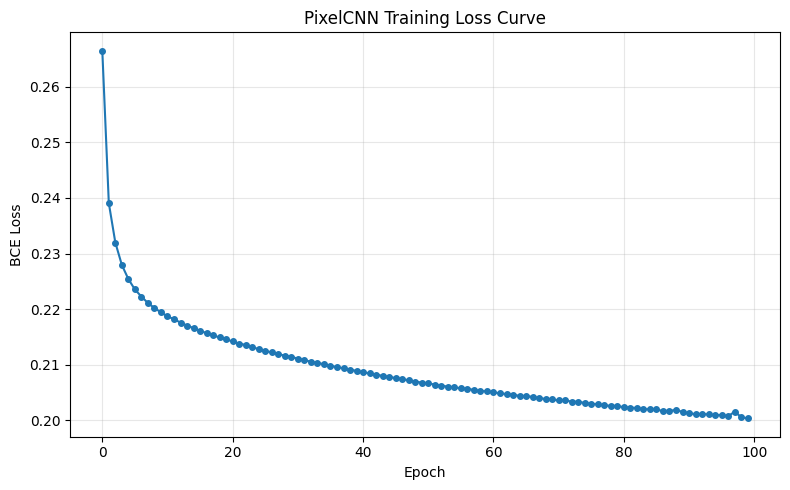


Final model saved to checkpoints/pixelcnn_final.pth
Total training time: 1573.49s
Inference time for 10 images: 0.7666s


In [8]:
# Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(losses, marker='o', markersize=4)
plt.title("PixelCNN Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


torch.save(model.state_dict(), "checkpoints/pixelcnn_final.pth")
print(f"\nFinal model saved to checkpoints/pixelcnn_final.pth")
# print(f"Best model was saved when validation loss reached: {best_val_loss:.4f}")


print(f"Total training time: {total_train_time:.2f}s")
print(f"Inference time for 10 images: {inference_time:.4f}s")

In [9]:
def generate_sample_with_temperature(model, temperature=1.0, device='cpu'):
    model.eval()
    with torch.no_grad():
        x = torch.zeros(1, 1, 28, 28).to(device)
        for i in range(28):
            for j in range(28):
                logits = model(x)
                logit_here = logits[0, i, j]
                prob = torch.sigmoid(logit_here / temperature)
                pixel = torch.bernoulli(prob.unsqueeze(0).unsqueeze(0))
                x[0, 0, i, j] = pixel.item()
        return x.squeeze().cpu()

In [14]:
samples_per_temperature = 10
temperatures = [0.5, 0.8, 1.0, 1.2, 1.5]
all_samples = []

Generating samples with different temperatures...
  → Temperature = 0.5
  → Temperature = 0.8
  → Temperature = 1.0
  → Temperature = 1.2
  → Temperature = 1.5


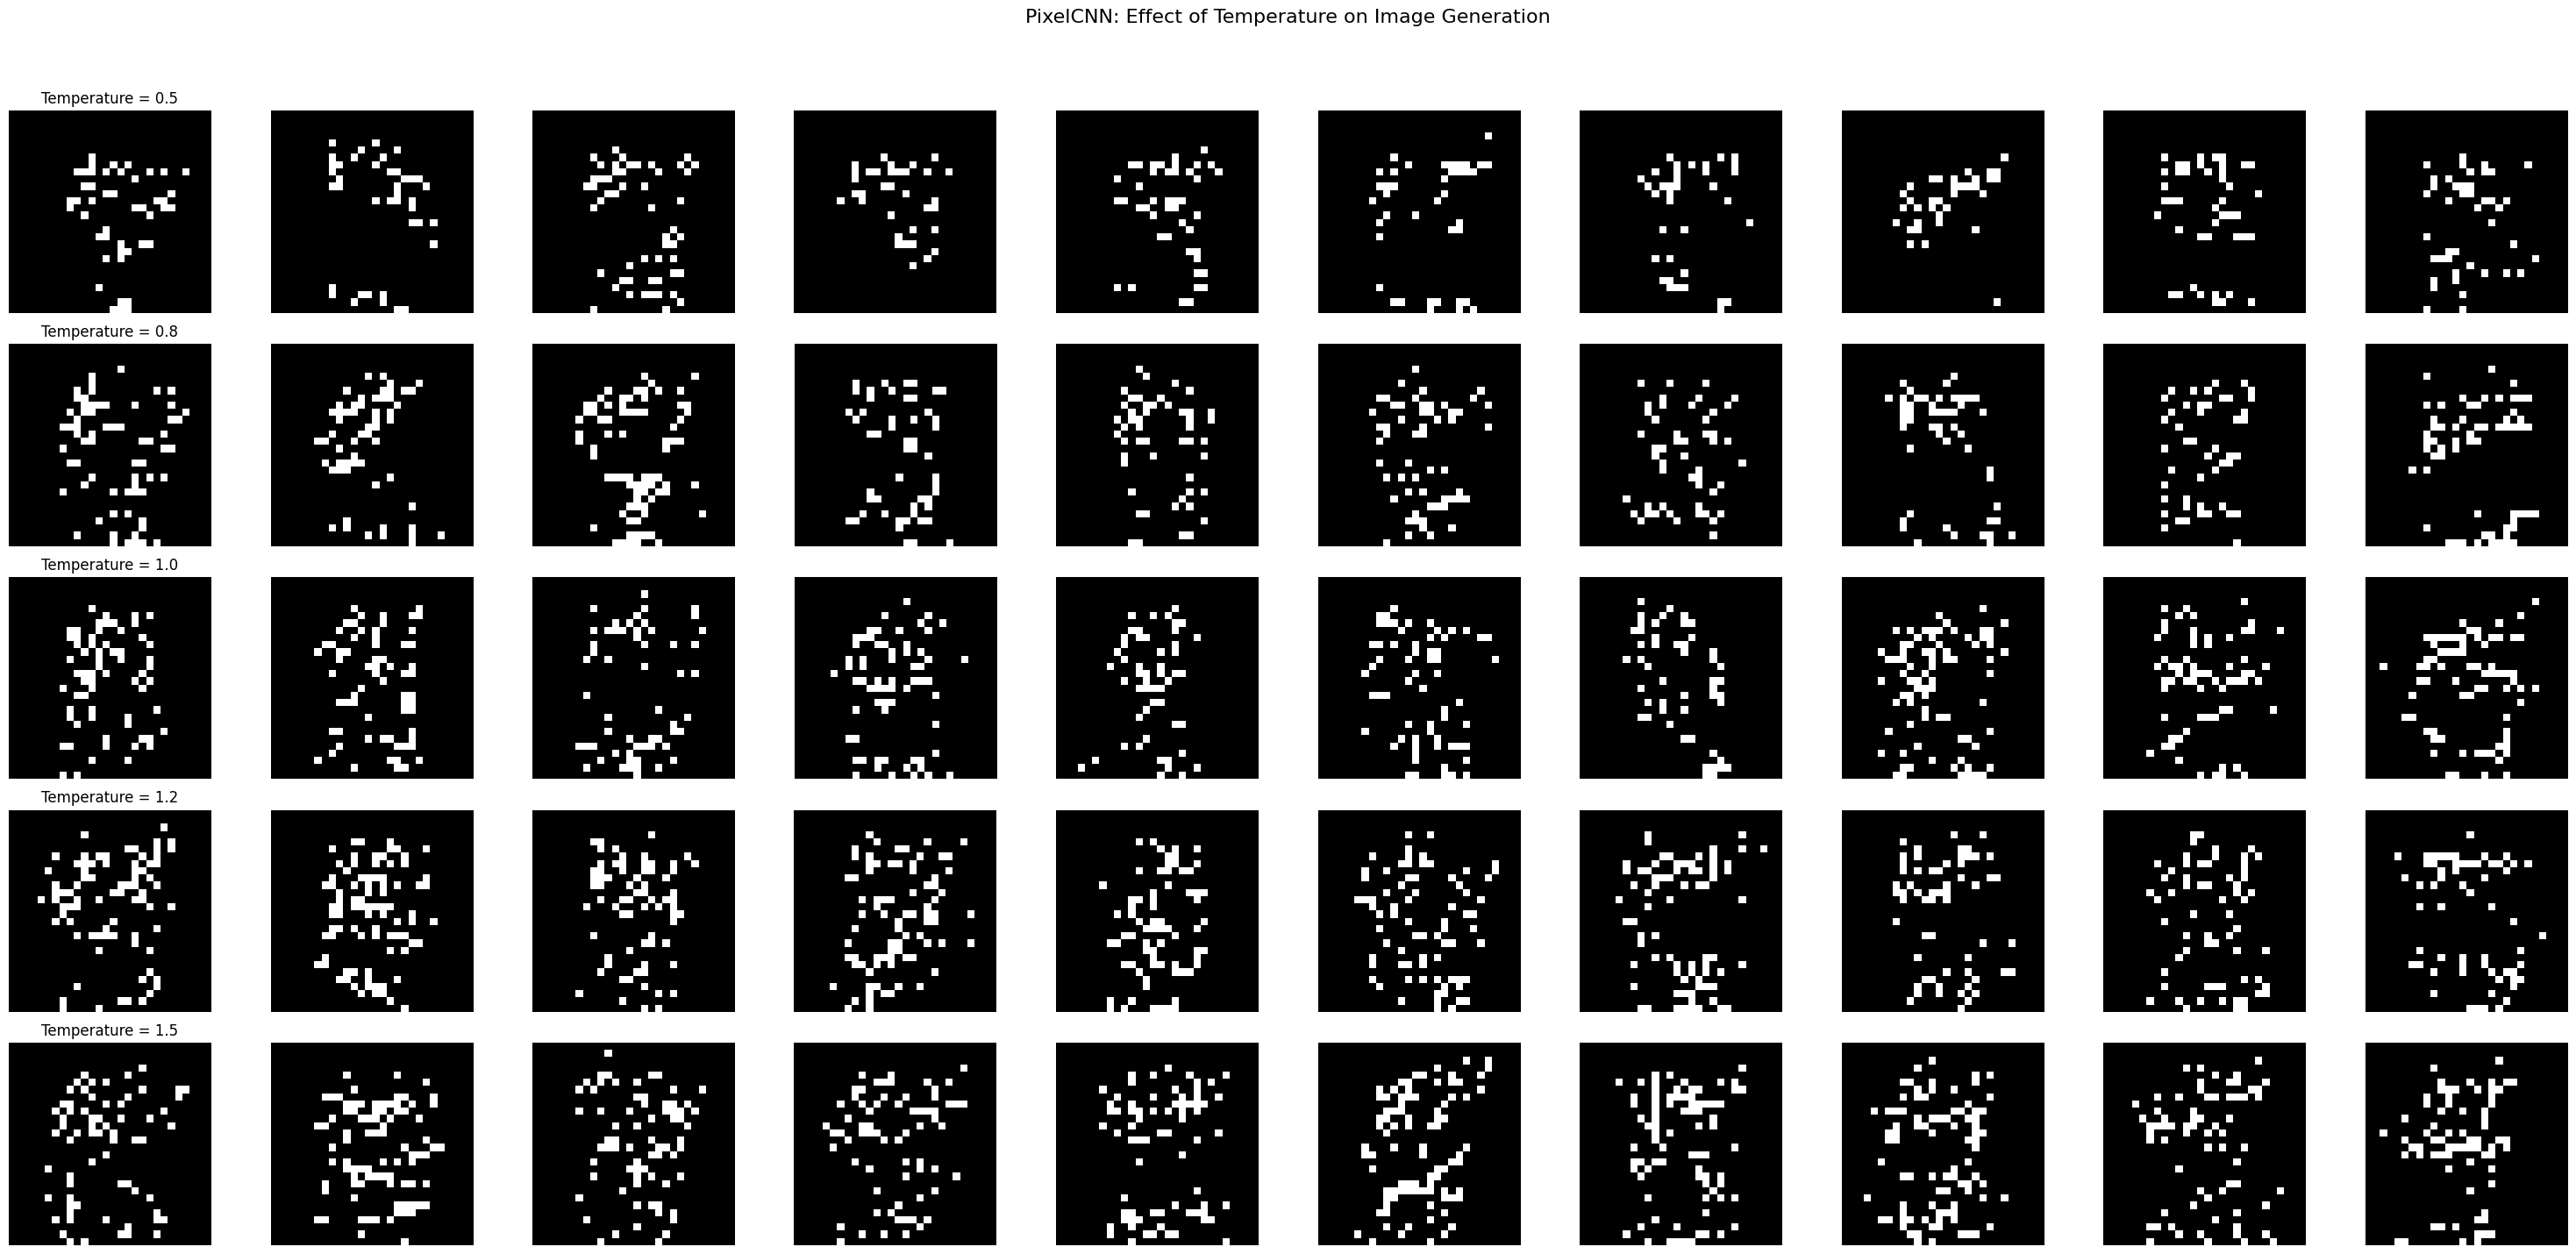

In [15]:
print("Generating samples with different temperatures...")
for T in temperatures:
    print(f"  → Temperature = {T}")
    temp_samples = []
    for _ in range(samples_per_temperature):
        sample = generate_sample_with_temperature(model, temperature=T, device=device)
        temp_samples.append(sample)
    all_samples.append(temp_samples)

fig = plt.figure(figsize=(samples_per_temperature * 3, len(temperatures) * 3))
for idx_t, (T, temp_samples) in enumerate(zip(temperatures, all_samples)):
    for idx_s, sample in enumerate(temp_samples):
        plt.subplot(len(temperatures), samples_per_temperature, idx_t * samples_per_temperature + idx_s + 1)
        plt.imshow(sample, cmap='gray')
        if idx_s == 0:
            plt.title(f'Temperature = {T}')
        plt.axis('off')

plt.suptitle('PixelCNN: Effect of Temperature on Image Generation', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()